First up, a data generating process that should be pretty hard to guess at:

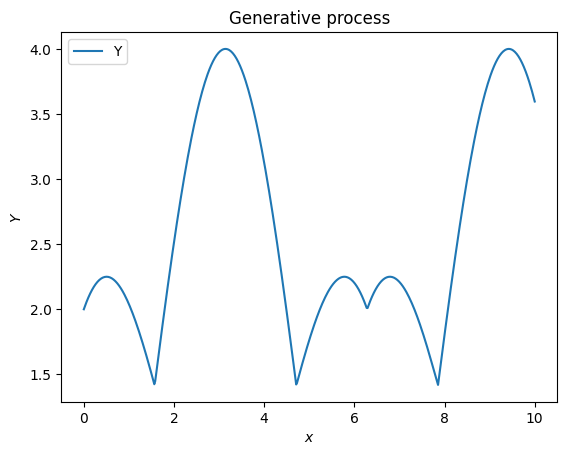

In [85]:
import numpy as np

X = np.linspace(start=0, stop=10, num=500)
X2 = np.squeeze(X + (2 * abs(np.cos(X))))
X3 = np.squeeze(X - (2 * abs(np.sin(X / 2))))

y = np.subtract(X2, X3)
#y = np.subtract(y, X3)

import matplotlib.pyplot as plt

plt.plot(X, y, label=r"Y")
# plt.plot(X, X2, label=r"X2", linestyle="dotted")
# plt.plot(X, X3, label=r"X3", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$Y$")
_ = plt.title("Generative process")

Pick 10 points that our GPR will guess at:

In [86]:
rng = np.random.RandomState(42)
training_indices = rng.choice(np.arange(y.size), size=10, replace=False)

Xs = np.array([X,X2,X3]).transpose()

X_train = [[],[],[]]

for ind in training_indices:
    X_train[0].append(X[ind])
    X_train[1].append(X2[ind])
    X_train[2].append(X3[ind])

X_train = np.array(X_train).transpose()

y_train = y[training_indices]

Now train using the RBF kernel:

In [164]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel


kernel = RBF(length_scale=0.7, length_scale_bounds=(0.00001, 1000))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

RBF(length_scale=3.21)

Now predict using our GPR

In [165]:
mean_prediction, std_prediction = gaussian_process.predict(Xs, return_std=True)

/Users/joshua.noble/projects/GPR/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:441: RuntimeWarning: divide by zero encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/joshua.noble/projects/GPR/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:441: RuntimeWarning: overflow encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/joshua.noble/projects/GPR/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:441: RuntimeWarning: invalid value encountered in matmul
  y_mean = K_trans @ self.alpha_


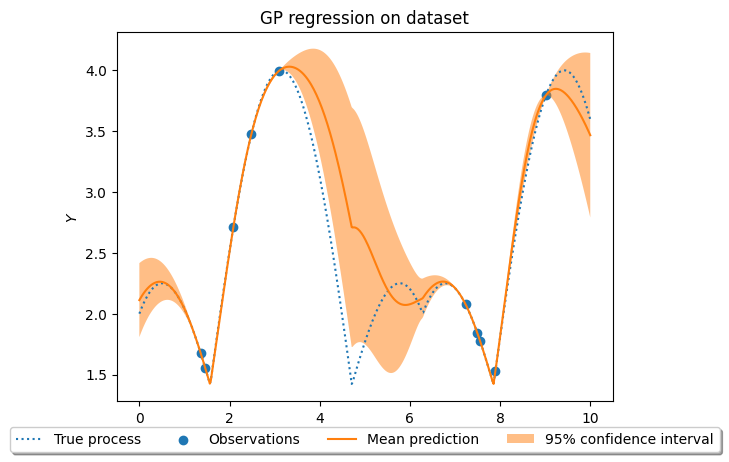

In [166]:

plt.plot(X, y, label=r"True process", linestyle="dotted")
plt.scatter(X_train.transpose()[0], y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.xlabel("$x$")
plt.ylabel("$Y$")
_ = plt.title("GP regression on dataset")

So it's pretty good. Now let's add noise.

In [142]:
noise_std = 0.25
y_train_noisy = y_train + rng.normal(loc=0.0, scale=noise_std, size=y_train.shape)


In [ ]:
# retrain

# gaussian_process = GaussianProcessRegressor(
#     kernel=kernel, alpha=noise_std**2, n_restarts_optimizer=9
# )

kernel_rbf_lin = RBF(length_scale=2.5, length_scale_bounds=(0.00001, 100)) + ConstantKernel(0.5)

gaussian_process = GaussianProcessRegressor(
    kernel=kernel_rbf_lin, alpha=0.1, n_restarts_optimizer=9
)

gaussian_process.fit(X_train, y_train_noisy)
mean_prediction, std_prediction = gaussian_process.predict(Xs, return_std=True)

/Users/joshua.noble/projects/GPR/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:441: RuntimeWarning: divide by zero encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/joshua.noble/projects/GPR/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:441: RuntimeWarning: overflow encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/joshua.noble/projects/GPR/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:441: RuntimeWarning: invalid value encountered in matmul
  y_mean = K_trans @ self.alpha_


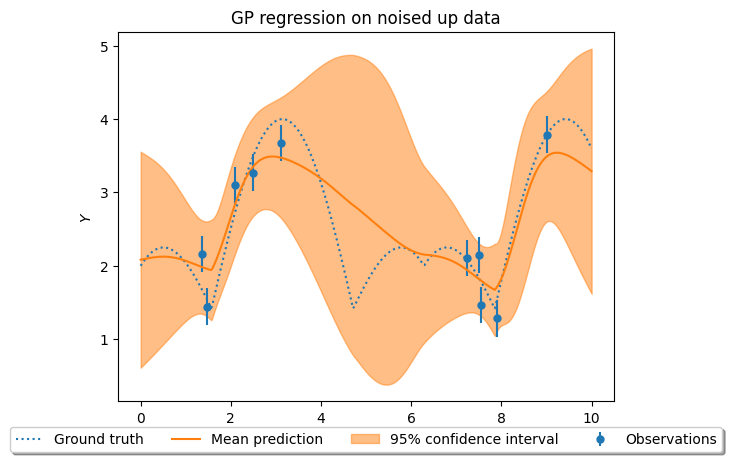

In [192]:
plt.plot(X, y, label=r"Ground truth", linestyle="dotted")
plt.errorbar(
    X_train.transpose()[0],
    y_train_noisy,
    noise_std,
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations",
)
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
#           ncol=3, fancybox=True, shadow=True)

# Put a legend below current axis
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

plt.xlabel("$X$")
plt.ylabel("$Y$")
_ = plt.title("GP regression on noised up data")

In [127]:

from sklearn.gaussian_process.kernels import ExpSineSquared

kernel_ess = ConstantKernel() + Matern(length_scale=1.0, length_scale_bounds=(0.00001, 10000)) + WhiteKernel(noise_level=4.0)

gaussian_process_ess = GaussianProcessRegressor(
    kernel=kernel_ess, alpha=1.0, n_restarts_optimizer=50, normalize_y=False, optimizer='fmin_l_bfgs_b', random_state=None
)

gaussian_process_ess.fit(X_train, y_train_noisy)
mean_prediction, std_prediction = gaussian_process_ess.predict(Xs, return_std=True)

/Users/joshua.noble/projects/GPR/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshua.noble/projects/GPR/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:441: RuntimeWarning: divide by zero encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/joshua.noble/projects/GPR/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:441: RuntimeWarning: overflow encountered in matmul
  y_mean = K_trans @ self.alpha_
/Users/joshua.noble/projects/GPR/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:441: RuntimeWarning: invalid value encountered in matmul
  y_mean = K_trans @ self.alpha_


ESS kernel 

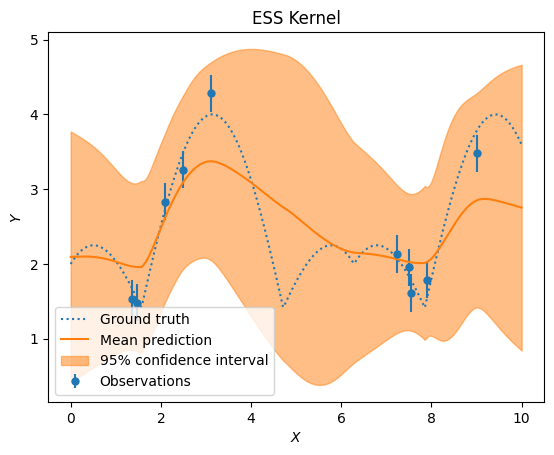

In [128]:
plt.plot(X, y, label=r"Ground truth", linestyle="dotted")
plt.errorbar(
    X_train.transpose()[0],
    y_train_noisy,
    noise_std,
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations",
)
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$X$")
plt.ylabel("$Y$")
_ = plt.title("ESS Kernel")